# Transfer learning using Keras

## Imports and constants

In [28]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from owkin.ml import train_subjects_classifier
from pathlib import Path
import logging
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# data properties:
HEIGHT = 224 # our images height (in pixels)
WIDTH = 224 # our images width (in pixels)
CHANNELS = 3 # our images channels (i.e. RVB)
DATA_DIR = 'data' # data directory where .csv files are stored
IMAGES_DIR = 'data/train_input/images' # directory where images are stored
TEST_IMAGES_DIR = 'data/test_input/images' # directory where images are stored
BEST_MODEL_FILENAME = 'models/best_transfer_learning.hd5' # output model filename

# deep neural network architecture:
HIDDEN_LAYER_SIZE = 32 # number of units in the last dense layer
OUTPUT_LAYER_SIZE = 2 # number of classes to predict (here "non-tumoral" and "tumoral")
RESNET_POOLING = 'avg' # ['avg' | 'max' ]

# training procedure hyperparameters:
VALIDATION_SPLIT = 0.2 # proportion of images to be reserved for the validation dataset
BATCH_SIZE = 8
NUM_EPOCHS = 10
STEPS_PER_EPOCH_TRAINING = 1000 # number of times a batch of images should be generated per epoch
STEPS_PER_EPOCH_VALIDATION = 10
LOSS_FUNCTION = 'categorical_crossentropy'
METRICS = ['accuracy']

# optimizer hyperparameters:
LEARNING_RATE = 0.01
DECAY = 1e-6
MOMENTUM = 0.9

# others:
SEED = 42 # seed number for reproducibility of the training validation splits

## Model definition

We want to use a pretrained version of ResNet50, on the ImageNet dataset, and fine-tune it in order to classify tumoral from non-tumoral tiles. To do so, we add fully-connected (FC or Dense) layers and train them on our annotated dataset.

In [32]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential([
        ResNet50(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, CHANNELS), pooling=RESNET_POOLING),
        Dense(HIDDEN_LAYER_SIZE, activation='relu'),
        Dense(OUTPUT_LAYER_SIZE, activation='softmax')
    ])
    
    # we do not train the ResNet50 layer since it is already pre-trained on the ImageNet dataset
    model.layers[0].trainable = False
    
    return model

model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 32)                65568     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 23,653,346
Trainable params: 65,634
Non-trainable params: 23,587,712
_________________________________________________________________


## Image generator

Since our dataset contains "only" arround 10k images, we might need to *augment* it, that's **data augmentation**. It consists, in our case, in rotating or flipping the tiles to make as if they were different images.

In [4]:
annot_tiles_filename = DATA_DIR + "/train_input" + "/train_tile_annotations.csv"
logging.debug(f'reading csv file: {annot_tiles_filename}')
annot_tiles_df = pd.read_csv(annot_tiles_filename)

Let's visualize the `csv` file content:

In [5]:
annot_tiles_df.head()

,Unnamed: 0,Target
0,ID_387_annotated_tile_0_15_69_30.jpg,0.0
1,ID_387_annotated_tile_1_15_23_53.jpg,0.0
2,ID_387_annotated_tile_2_15_58_20.jpg,0.0
3,ID_387_annotated_tile_3_15_67_12.jpg,0.0
4,ID_387_annotated_tile_4_15_57_20.jpg,0.0


We have to convert the `Target` column to `str` for the `ImageDataGenerator`.

In [6]:
annot_tiles_df['Target'] = annot_tiles_df['Target'].apply(lambda x: str(x))
# annot_tiles_df['Unnamed: 0'] = annot_tiles_df['Unnamed: 0'].apply(lambda x: x[:6]+'/'+x)

We create an image generator that will load on-the-fly batches of images in memory; raw and/or augmented (i.e. artifical) ones. The dataset will be randomly split in training and validation sets according to the `VALIDATION_SPLIT` parameter.

In [7]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

data_generator =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
)

training_generator = data_generator.flow_from_dataframe(
    subset='training', # set it as the training dataset
    dataframe=annot_tiles_df, x_col='Unnamed: 0', y_col='Target',
    directory=IMAGES_DIR, # images directory where are stored files whose filenames are listed in the `x_col` of the dataframe
    seed=SEED,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = data_generator.flow_from_dataframe(
    subset='validation', # set it as the validation dataset
    dataframe=annot_tiles_df, x_col='Unnamed: 0', y_col='Target',
    directory=IMAGES_DIR, # images directory where are stored files whose filenames are listed in the `x_col` of the dataframe
    seed=SEED,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 6607 images belonging to 2 classes.
Found 1651 images belonging to 2 classes.


## Model training

### Optimizer and callbacks

In [8]:
import tensorflow as tf
import random, string

# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value
    
def random_id(length=4):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))

In [9]:
from keras.optimizers import SGD, Adam

sgd = SGD(lr=LEARNING_RATE, decay=DECAY, momentum=MOMENTUM, nesterov=True)
model.compile(optimizer=sgd, loss=LOSS_FUNCTION, metrics=['accuracy', auc_roc])

from keras.callbacks import ModelCheckpoint, TensorBoard
checkpoint_cb = ModelCheckpoint(filepath=BEST_MODEL_FILENAME, 
                                monitor='val_auc_roc', 
                                save_best_only=True)
tensorboard_cb = TensorBoard(log_dir=f'logs/{random_id()}', 
                             batch_size=BATCH_SIZE, 
                             write_graph=True,
                             update_freq='batch')

Instructions for updating:
Please switch to tf.metrics.auc. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### Training

In [ ]:
model.fit_generator(
    training_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
    epochs = NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    callbacks=[checkpoint_cb, tensorboard_cb]
)

Instructions for updating:
Use tf.cast instead.


Epoch 1/10
 509/1000 [==============>...............] - ETA: 26:09 - loss: 0.1088 - acc: 0.9745 - auc_roc: 0.9771

## Training of the subject's classifier

### Model loading

In [34]:
model.load_weights(BEST_MODEL_FILENAME)

### Training data loading

In [36]:
logging.getLogger().setLevel(logging.INFO)

In [64]:
from keras.applications.resnet50 import preprocess_input
from owkin.io import load_training_images

train_image_iterator, train_filenames_df, train_output = load_training_images(
    data_dir=Path('data'),
    target_size=(HEIGHT,WIDTH),
    batch_size=BATCH_SIZE,
    preprocessing_function=preprocess_input,
    with_annotated=False
)

listing data/train_input/images...
the folder contains 2 subjects
  extracting subjects 014's image filenames
  extracting subjects 098's image filenames
Found 2000 validated image filenames.
reading csv file: data/training_output.csv


### Prediction on the non-annotated training set

In [65]:
train_image_iterator.reset() # to be sure we're in line with the filenames in the DataFrame
y_train_pred = model.predict_generator(train_image_iterator, steps=len(train_image_iterator), verbose=1)

250/250 [==============================] - 559s 2s/step


In [67]:
train_filenames_df['Target'] = np.zeros(len(train_filenames_df))
train_filenames_df['Target'].iloc[:len(y_train_pred)] = y_train_pred[:,1]

In [68]:
train_filenames_df.head()

,ID,Filename,Target
0,014,ID_014/ID_014_tile_0_16_16_173.jpg,0.003193
1,014,ID_014/ID_014_tile_100_16_42_182.jpg,0.001437
2,014,ID_014/ID_014_tile_101_16_81_161.jpg,0.011184
3,014,ID_014/ID_014_tile_102_16_51_219.jpg,0.002060
4,014,ID_014/ID_014_tile_103_16_48_218.jpg,0.002991


### Subject-level feature extraction from tiles prediction

In [82]:
N_SUBJECTS_FEATURES = 30

def project_as_histogram(x, bins=N_SUBJECTS_FEATURES):
    """Project a probabilities vector to an histogram representation.
    
    Args:
        x: a vector of probabilities of length `n_tiles`
        bins (int): size of the histogram output vector 

    Returns: the histogram vector of length `bins`, containing the proportion of 
        values   

    """
    counts, _ = np.histogram(x, bins=bins, range=(0,1))
    return counts / sum(counts)

x_train_2 = train_filenames_df.groupby('ID').apply(lambda x: project_as_histogram(x['Target']))
x_train_2 = np.vstack(x_train_2)

y_train_2 = train_output['Target'].values

In [92]:
x_train_2.shape

(2, 30)

Let's visualize random features sets for this seconds training set, at a subject's level:

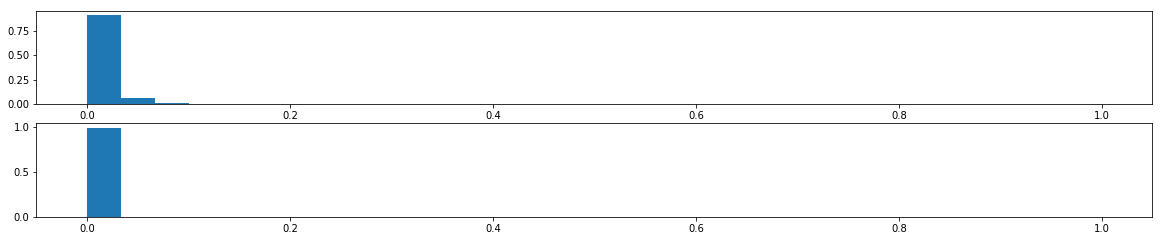

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

N_PLOTTED_SUBJECTS = 5
step = 1/N_SUBJECTS_FEATURES
x_plotted = np.arange(0+step/2,1,step=step)

plt.figure(figsize=(20,2*N_PLOTTED_SUBJECTS))
for i in range(min(N_PLOTTED_SUBJECTS,len(x_train_2))):
    plt.subplot(N_PLOTTED_SUBJECTS,1,i+1)
    plt.bar(x=x_plotted, height=x_train_2[i,:], width=step)

### Training of the subjects classifier

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

NUM_RUNS = 10
NUM_SPLITS = 5

aucs = []
for seed in range(NUM_RUNS):
    logging.info(f"  run {seed + 1}/{NUM_RUNS}:")
    
    # Reset the classifier and its cross-val
    estimator = RandomForestClassifier(n_estimators=20)
    cv = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=seed)
    
    # Cross-validate
    auc = cross_val_score(estimator, cv=cv, X=x_train_2, y=y_train_2, n_jobs=-1, scoring="roc_auc", verbose=3)

    logging.debug(f"    auc={auc}")
    aucs.append(auc)

aucs = np.array(aucs)
logging.info("  auc: mean {}, std {}".format(aucs.mean(), aucs.std()))

  run 1/10:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


ValueError: got predict_proba of shape (1, 1), but need classifier with two classes for roc_auc_score scoring

## Test and submission

### Model loading

We load the best model's weights learnt so far.

In [21]:
model.load_weights(BEST_MODEL_FILENAME)

### Test data loading

Now, let's load all the test subject's images in the same maner we loaded the training data: by flowing from an `ImageDataGenerator`. Except that here the original class provided by the official `keras` library has been patched to support subfolders (see `owkin.utils.load_test_images` function for more info). 

In [76]:
from keras.applications.resnet50 import preprocess_input

logging.getLogger().setLevel(logging.INFO) # we don't want every filename displayed
test_data_generator, test_filenames_df = utils.load_test_images(
    data_dir=Path('data'),
    target_size=(HEIGHT,WIDTH),
    batch_size=BATCH_SIZE,
    preprocessing_function=preprocess_input
)

listing data/test_input/images...
the folder contains 58 subjects
  extracting subjects 004's image filenames
  extracting subjects 016's image filenames
  extracting subjects 017's image filenames
  extracting subjects 020's image filenames
  extracting subjects 028's image filenames
  extracting subjects 032's image filenames
  extracting subjects 034's image filenames
  extracting subjects 042's image filenames
  extracting subjects 044's image filenames
  extracting subjects 050's image filenames
  extracting subjects 059's image filenames
  extracting subjects 060's image filenames
  extracting subjects 074's image filenames
  extracting subjects 080's image filenames
  extracting subjects 087's image filenames
  extracting subjects 092's image filenames
  extracting subjects 095's image filenames
  extracting subjects 108's image filenames
  extracting subjects 109's image filenames
  extracting subjects 115's image filenames
  extracting subjects 125's image filenames
  extracti

In [74]:
test_filenames_df.head(n=BATCH_SIZE)

,ID,Filename
0,004,ID_004/ID_004_tile_0_16_65_183.jpg
1,004,ID_004/ID_004_tile_100_16_96_117.jpg
2,004,ID_004/ID_004_tile_101_16_94_157.jpg
3,004,ID_004/ID_004_tile_102_16_46_111.jpg
4,004,ID_004/ID_004_tile_103_16_28_110.jpg
5,004,ID_004/ID_004_tile_104_16_91_102.jpg
6,004,ID_004/ID_004_tile_105_16_65_111.jpg
7,004,ID_004/ID_004_tile_106_16_88_124.jpg


Let's visualize one batch of images, to check we have the images in the right order.

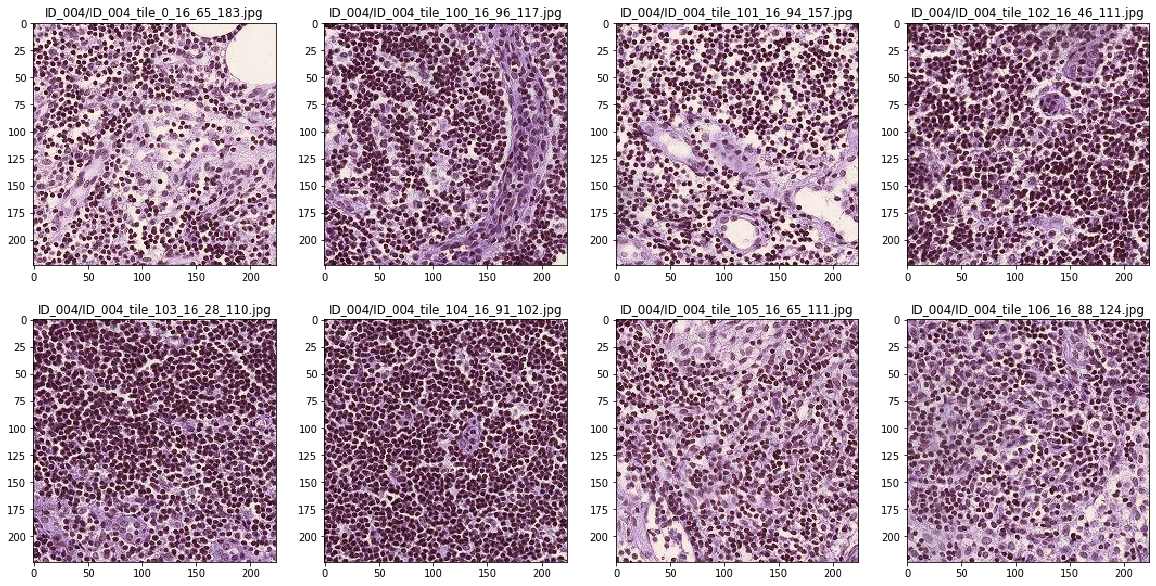

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

def unpreprocess_image(im):
    """Undo the preprocessing done for the ResNet50 network."""
    im2 = (im - np.min(im)) / (np.max(im) - np.min(im)) * 255 
    im2 = im2.astype(np.uint8)
    return im2

plt.figure(figsize=(20,30))
test_data_generator.reset()
images_batch = test_data_generator.next()
for i in range(BATCH_SIZE):
    plt.subplot(2,4,i+1)
    plt.title(test_filenames_df['Filename'][i])
    plt.imshow(unpreprocess_image(images_batch[i,:,:,:]))

### Predictions on public the test set

In [77]:
test_data_generator.reset() # to be sure we're in line with the filenames in the DataFrame
y_test_pred = model.predict_generator(test_data_generator, steps=375, verbose=1)

375/375 [==============================] - 1548s 4s/step


Let's randomly visualize some of the tumoral tiles:

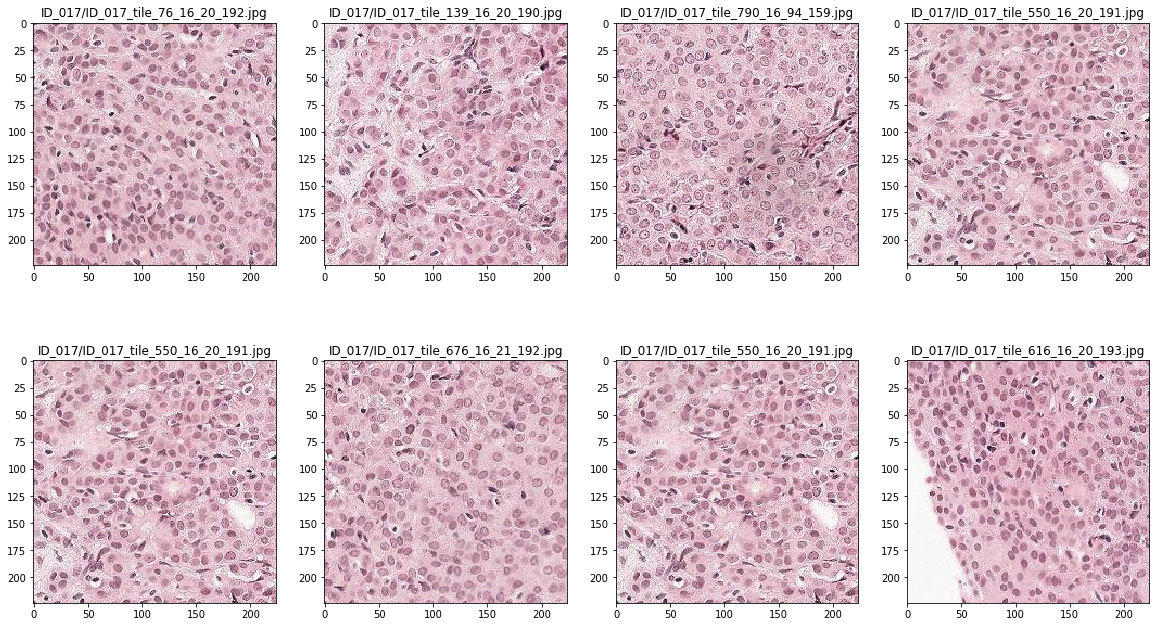

In [139]:
import matplotlib.image as mpimg

tumoral_ids = np.where(np.argmax(y_test, axis=1))[0]
rand_tumoral_ids = np.random.choice(tumoral_ids, size=8)

plt.figure(figsize=(20,30))
for i, im_path in enumerate(test_filenames_df['Filename'].iloc[rand_tumoral_ids]):
    im = mpimg.imread(DATA_DIR + '/test_input/images/' + im_path)
    plt.subplot(5,4,i+1)
    plt.title(im_path)
    plt.imshow(im)

In [144]:
test_output = test_filenames_df.copy()
test_output['Target'] = np.zeros(len(test_output))
test_output['Target'].iloc[:len(y_test)] = y_test[:,1]

In [196]:
x_test_2 = test_output.groupby('ID').apply(lambda x: project_as_histogram(x['Target']))

### Simple solution

Define the prediction score as the mean probabability of the tiles for being tumoral.

In [156]:
TUMORAL_PROB_THRESHOLD = 0.3
test_output.groupby('ID').apply(lambda x: np.mean(x[x['Target'] > TUMORAL_PROB_THRESHOLD]['Target']))

ID
004    0.310797
016    0.500491
017    0.437359
020         NaN
028         NaN
032         NaN
034         NaN
042         NaN
044         NaN
050         NaN
059         NaN
060         NaN
074         NaN
080         NaN
087         NaN
092         NaN
095         NaN
108         NaN
109         NaN
115         NaN
125         NaN
130         NaN
138         NaN
164         NaN
171         NaN
182         NaN
183         NaN
190         NaN
198         NaN
199         NaN
225         NaN
237         NaN
263         NaN
264         NaN
265         NaN
271         NaN
276         NaN
297         NaN
302         NaN
303         NaN
316         NaN
317         NaN
318         NaN
319         NaN
321         NaN
326         NaN
328         NaN
332         NaN
334         NaN
358         NaN
359         NaN
360         NaN
361         NaN
381         NaN
388         NaN
389         NaN
392         NaN
395         NaN
dtype: float64

## What's left to do

- [ ] Optimize, optimize, optimize the hyperparameters !
- [x] Predict tiles label on test data using a DataFrame to keep track of the subjects IDs
- [ ] Infer weak labels of test subjects
- [ ] Submit the result 